<a href="https://colab.research.google.com/github/pallavi-allada/UtteranceClassification/blob/main/src/Transformers_BERT_Utterance_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transformer based encodings to check if the context-aware embeddings provide better performance than the static embeddings of word2vec.

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.7MB/s 
     |████████████████████████████████| 901kB 45.5MB/s 
     |████████████████████████████████| 3.3MB 52.4MB/s 


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os as os

import torch
import torchtext
import torch.nn as nn
from torchtext.legacy.data import Field, Dataset, BucketIterator, Iterator, Example
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertModel

import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split

In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer, BertModel,BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
ROOT_DIR = "/content/drive/MyDrive/Colab Notebooks/Cognizer"

DATA_DIR = "data"
MODEL_DIR = "models"

TRAIN_CSV = "train.csv"
TEST_CSV = "test.csv"

Read train and test data from CSV files and make Examples for creating an Iterator - BucketIterator, to be able to batch the examples of same length together for processing.

In [ ]:
train = pd.read_csv(os.path.join(ROOT_DIR,DATA_DIR,TRAIN_CSV))
test = pd.read_csv(os.path.join(ROOT_DIR,DATA_DIR,TEST_CSV))
train.shape, test.shape

((4137, 3), (460, 3))

In [ ]:
#convert tag to label
def tag2label(tag):
  return (0 if tag == "Contract" else (1 if tag == "Email" else (2 if tag == "Calendar" else (3 if tag == "Contact" else (4 if tag == "Document" else (5 if tag == "Employee" else 6))))))

#convert label to tag
def label2tag(lbl):
  return ("Contract" if lbl == 0 else ("Email" if lbl == 1 else ("Calendar" if lbl == 2 else ("Contact" if lbl == 3 else ("Document" if lbl == 4 else ("Employee" if lbl == 5 else "Keyword"))))))

train["label"] = train["tags"].apply(tag2label)
test["label"] = test["tags"].apply(tag2label)

In [ ]:
NUM_CLASSES = len(train["label"].unique())
NUM_CLASSES

7

Identifying the max sentence length in the given training data

In [ ]:
train["length"] = train["question"].apply(lambda x: len(x.split()))
max(train["length"])

28

The longest sentence in the train set is 28 words, but we need to identify what is the max number of tokens that the BertTokenizer splits the sentences into. This will. be useful for padding later.

We need to convert text to numbers, by following the requirements:

1)Add special tokens to separate sentences and do classification

2)Pass sequences of constant length (introduce padding)

3)Create array of 0s (pad token) and 1s (real token) called attention mask

The Transformers library provides a wide variety of Transformer models (including BERT. 
We can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. 

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Lets try to tokenise using an example and convert to numbers

In [ ]:
sample_ques = "What are some services offered by Autodesk?"
tokens = tokenizer.tokenize(sample_ques)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_ques}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: What are some services offered by Autodesk?
   Tokens: ['what', 'are', 'some', 'services', 'offered', 'by', 'auto', '##des', '##k', '?']
Token IDs: [2054, 2024, 2070, 2578, 3253, 2011, 8285, 6155, 2243, 1029]


As mentioned in first requirement, we need to add special token to the converted sentence like

[CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification.

[SEP] - marker for ending of a sentence

[PAD] - for padding

[UNK] - for unknown tokens


In [ ]:
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[CLS] 101
[SEP] 102
[PAD] 0
[UNK] 100


This requirement can be accomplished by the encode_plus() method. The token_ids are stored in a tensor and padded to 30.

In [ ]:
encoding = tokenizer.encode_plus(sample_ques,
  max_length= 30, #MAX_LEN but for now padding to 30
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  # pad_to_max_length=True, #This is deprecated 
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

In [ ]:
print(encoding.keys() )
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'][0], encoding['attention_mask'][0])

dict_keys(['input_ids', 'attention_mask'])
30
tensor([ 101, 2054, 2024, 2070, 2578, 3253, 2011, 8285, 6155, 2243, 1029,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])


Cross checking the tokens from ids

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'what',
 'are',
 'some',
 'services',
 'offered',
 'by',
 'auto',
 '##des',
 '##k',
 '?',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Let's identify the max length of token of the questions 

In [ ]:
token_lens = []

for txt in train.question:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

print("Maximum number of tokens:",max(token_lens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Maximum number of tokens: 48


In [ ]:
MAX_LEN = 50
BATCH_SIZE = 16
NUM_WORKERS = 2

In [ ]:
class UtteranceDataset(Dataset):

  def __init__(self, questions, labels, tokenizer, max_len):
    self.questions = questions
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.questions)
  
  def __getitem__(self, item):
    question = str(self.questions[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      question,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      # pad_to_max_length=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'questions': question,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

In [ ]:
#Helper function to create data loader
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = UtteranceDataset(
    questions=df["question"].to_numpy(),
    labels=df["label"].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(ds,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS)

In [ ]:
train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's take a look at an example data from loader

In [ ]:
data = next(iter(train_data_loader))
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

dict_keys(['questions', 'input_ids', 'attention_mask', 'labels'])
torch.Size([16, 50])
torch.Size([16, 50])
torch.Size([16])


Let's try to create a BertModel and try to pass the sample question to it

In [ ]:
bert_model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME,num_labels=NUM_CLASSES,output_attentions=False,output_hidden_states=False)
                                                      
bert_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
output = bert_model(input_ids=data['input_ids'].to(device), token_type_ids=None, attention_mask=data['attention_mask'].to(device), labels = data['labels'].to(device))
print(output.loss, output.logits)

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0375,  0.2770,  0.7672,  0.2584, -0.0080,  0.0137,  0.5587],
        [-0.0332,  0.2947,  0.6791,  0.2202, -0.0179, -0.0071,  0.5931],
        [-0.0109,  0.2691,  0.7307,  0.1975, -0.0335,  0.0448,  0.5731],
        [-0.0696,  0.1742,  0.8161,  0.1917,  0.0286,  0.0543,  0.5483],
        [-0.0504,  0.2092,  0.8087,  0.2331,  0.0118,  0.0056,  0.4869],
        [-0.0533,  0.0277,  0.9455,  0.1666, -0.0800,  0.0288,  0.5003],
        [-0.0497,  0.1646,  0.7926,  0.1420, -0.1282, -0.0130,  0.5324],
        [-0.0849,  0.3590,  0.5642,  0.1264, -0.0111, -0.1068,  0.5344],
        [-0.1246,  0.3165,  0.7448,  0.2394, -0.1365, -0.0532,  0.5919],
        [-0.1010,  0.1717,  0.8785,  0.1816, -0.0680, -0.0100,  0.5033],
        [-0.0657,  0.2547,  0.6975,  0.2650, -0.0165, -0.0011,  0.5914],
        [-0.0502,  0.2193,  0.7126,  0.2253, -0.0362, -0.0042,  0.5804],
        [ 0.0235,  0.1583,  0.9764,  0.2112, -0.1040,  0.0323,  0.4735],
        

# Model 

In [ ]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()
        self.encoder = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME,num_labels=NUM_CLASSES,output_attentions=False,output_hidden_states=False)

    def forward(self, text, attention_mask, label):
        # print("text in forward:", text)
        # print("label in forward:", label)
        outputs = self.encoder(input_ids=text, token_type_ids=None, attention_mask=attention_mask,labels= label)
        logits = outputs.logits
        loss = outputs.loss
        return loss, logits

In [ ]:
model_try = BERT().to(device)
loss, logits = model_try(data['input_ids'].to(device), data['attention_mask'].to(device), None)

print(loss, logits)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

None tensor([[ 0.7812,  0.1433, -0.2664, -0.0534, -0.2371, -0.0926,  0.5412],
        [ 0.8640,  0.1794, -0.3105, -0.0218, -0.2613, -0.1156,  0.5269],
        [ 0.7931,  0.1144, -0.2865, -0.0477, -0.1455, -0.1556,  0.5142],
        [ 0.7758,  0.0779, -0.2991, -0.0733, -0.1138, -0.1520,  0.5411],
        [ 0.6861,  0.0827, -0.2998, -0.0475, -0.2119, -0.1539,  0.5186],
        [ 0.7149,  0.1098, -0.2774, -0.1108,  0.0208, -0.2806,  0.6893],
        [ 0.6623,  0.2115, -0.2947,  0.0368, -0.1163, -0.2064,  0.5408],
        [ 0.8902,  0.0971, -0.3084,  0.0749, -0.3486, -0.0113,  0.4177],
        [ 0.8413,  0.1468, -0.3392,  0.0076, -0.2970, -0.1344,  0.4475],
        [ 0.7448,  0.2213, -0.2508, -0.0473, -0.1384, -0.2108,  0.5625],
        [ 0.8013,  0.1436, -0.3574, -0.0658, -0.2299, -0.1609,  0.5088],
        [ 0.7386,  0.2198, -0.3416, -0.0484, -0.2353, -0.1076,  0.5117],
        [ 0.6919,  0.1228, -0.3557, -0.0858, -0.0669, -0.2664,  0.5635],
        [ 0.9811,  0.1023, -0.2911,  0.0596, -

Methods to save and load best model

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):    
    state_dict = {'model_state_dict': model.state_dict(),'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    state_dict = torch.load(load_path, map_location=device)
    
    print(f'Model loaded from <== {load_path}')
    model.load_state_dict(state_dict['model_state_dict'])

    return state_dict['valid_loss']

In [ ]:
def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_metrics(load_path):
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [ ]:
EPOCHS = 5
def train(model,optimizer,criterion = nn.CrossEntropyLoss(), eval_every = len(train_data_loader) // 2, best_valid_loss = float("Inf")):
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0

    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(EPOCHS):
        for data in train_data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['labels'].to(device)
            
            loss,_ = model(input_ids, attention_mask, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for test_data in test_data_loader:
                        test_input_ids = test_data['input_ids'].to(device)
                        test_attention_mask = test_data['attention_mask'].to(device)
                        test_labels = test_data['labels'].to(device)
                        loss, _ = model(test_input_ids, test_attention_mask, test_labels)
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(test_data_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                #training progress
                print('\nEpoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, EPOCHS, global_step, EPOCHS*len(train_data_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(os.path.join(ROOT_DIR, MODEL_DIR,'model.pt'), model, best_valid_loss)
                    save_metrics(os.path.join(ROOT_DIR, MODEL_DIR,'metrics.pt'), train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(os.path.join(ROOT_DIR, MODEL_DIR,'metrics.pt'), train_loss_list, valid_loss_list, global_steps_list)
    


Training the model 

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch [1/5], Step [129/1295], Train Loss: 0.9850, Valid Loss: 0.4117
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Cognizer/models/model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Cognizer/models/metrics.pt

Epoch [1/5], Step [258/1295], Train Loss: 0.3507, Valid Loss: 0.2079
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Cognizer/models/model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Cognizer/models/metrics.pt

Epoch [2/5], Step [387/1295], Train Loss: 0.1615, Valid Loss: 0.1481
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Cognizer/models/model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Cognizer/models/metrics.pt

Epoch [2/5], Step [516/1295], Train Loss: 0.1411, Valid Loss: 0.1488

Epoch [3/5], Step [645/1295], Train Loss: 0.0735, Valid Loss: 0.1345
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Cognizer/models/model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Cogni

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Cognizer/models/metrics.pt


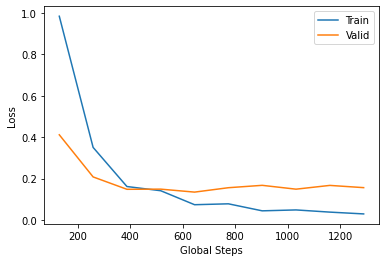

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(os.path.join(ROOT_DIR, MODEL_DIR,'metrics.pt'))
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

As data is less, using the data from test.csv that was used for validation during training to also create a classifiation report.

In [ ]:
# Evaluation Function

def evaluate(model):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        
        for test_data in test_data_loader:
            test_input_ids = test_data['input_ids'].to(device)
            test_attention_mask = test_data['attention_mask'].to(device)
            test_labels = test_data['labels'].to(device)
            _, logits = model(test_input_ids, test_attention_mask, None)

            y_pred.extend(torch.argmax(logits, 1).tolist())
            y_true.extend(test_labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[0,1,2,3,4,5,6], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4,5,6])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['0','1','2','3','4','5','6'])
    ax.yaxis.set_ticklabels(['0','1','2','3','4','5','6'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Cognizer/models/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.9814    0.9937    0.9875       159
           1     1.0000    0.9828    0.9913       116
           2     0.9512    0.9873    0.9689        79
           3     0.9318    0.9111    0.9213        45
           4     0.9000    0.9000    0.9000        40
           5     1.0000    1.0000    1.0000        13
           6     1.0000    0.7500    0.8571         8

    accuracy                         0.9696       460
   macro avg     0.9663    0.9321    0.9466       460
weighted avg     0.9698    0.9696    0.9693       460



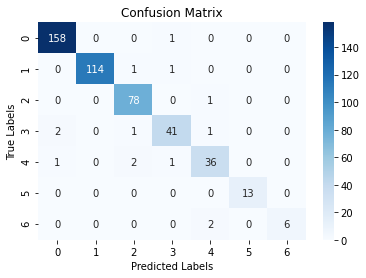

In [ ]:
best_model = BERT().to(device)
load_checkpoint(os.path.join(ROOT_DIR, MODEL_DIR,'model.pt'), best_model)
evaluate(best_model)

## Inference

In [ ]:
import time

def infer(question):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  encoding = tokenizer.encode_plus(
      question,
      add_special_tokens=True,
      max_length=70,
      return_token_type_ids=False,
      # pad_to_max_length=True,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
  best_model = BERT().to('cpu')
  load_checkpoint(os.path.join(ROOT_DIR, MODEL_DIR,'model.pt'), best_model)
  start_time = time.time()
  _, logits = best_model(encoding['input_ids'].to('cpu'), encoding['attention_mask'].to('cpu'), None)
  print("--- %s seconds ---" % (time.time() - start_time))
  print(label2tag(int(torch.argmax(logits).item())))
  
  
infer("show me all e-mail address of Pallavi")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Cognizer/models/model.pt
--- 0.18224883079528809 seconds ---
Contact


In [ ]:
import time
start_time = time.time()
best_model = BERT().to(device)
load_checkpoint(os.path.join(ROOT_DIR, MODEL_DIR,'model.pt'), best_model)

print("Predicted class - ", predict_class("show me all e-mail address of Pallavi", infer("KNN"))) #try with and without - in email
print("--- %s seconds ---" % (time.time() - start_time))